<a href="https://colab.research.google.com/github/vsmojver/machine_learning/blob/main/NLP_SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Build mulidmodal model and apply it to a text dataset (PubMedRCT200k)
# Conduct multiple experiments (token embeddings, character embeddings, pretrained embeddings, positional embeddings)

In [ ]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b9215677-cb9a-672c-dbf4-a343db53485e)


In [ ]:
# Get dataset from github
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct
     


Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 7.58 MiB/s, done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames
     

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [ ]:
# Data preprocessing
# Visualize data
# Create function to read document 

def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.
  
  Args:
      filename: a string containing the target filepath to read.
  
  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir+"train.txt")
train_lines[:27] # the whole first example of an abstract + a little more of the next one

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
#Abstract ID starts with ###xxx
# Sentance starts with \t and ends with \n


In [ ]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [ ]:
# Preprocess data
%%time
train_samples=preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples=preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir +"test.txt")
#len(train_samples), len(val_samples), len(test_samples)

CPU times: user 647 ms, sys: 109 ms, total: 755 ms
Wall time: 921 ms


In [ ]:
# Treate datasets 
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Dataset exploration
# Distribution of labels in dataset

train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

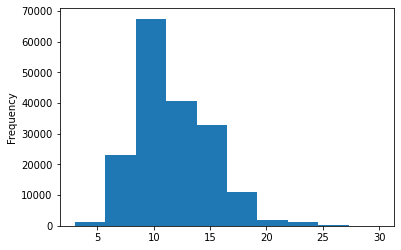

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
# Input into model is list of strings
# Convert abstract text lines into lists

train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# Encode labels (numeric values)
# Use one hot encoder (works better with tf)

# One hot encode labels

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot=one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
# extract labels and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Class names and number of classes from LabelEncoder instance

num_classes = len(label_encoder.classes_)
class_names=label_encoder.classes_

#show numbe of classes and class names
num_classes, class_names


(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [ ]:
# Model 0 - Baseline model
# Multinomial Naive Bayes

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create pipeline

model_0 = Pipeline ([ ("tf-idf", TfidfVectorizer()),
                     ("clf", MultinomialNB())])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded);

# Evaluate baseline model on validation dataset

model_0.score(X=val_sentences, y=val_labels_encoded)


0.7218323844829869

In [ ]:
# Make predictions

baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
# Helper funtion 1 (from previous notebook)
# Function to evaluate accuracy, precision, recall, f1-score

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
baseline_results = calculate_results(y_true=val_labels_encoded, y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
# Preprocessing for deep learning models
# Create vectorization layer: covert text to number
# Create embedding layers: capture realationship between numbers

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
     
# Avg len of sentences

sentence_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sentence_len=np.mean(sentence_lens)
avg_sentence_len

26.338269273494777

(array([1.25846e+05, 4.78220e+04, 5.37600e+03, 7.86000e+02, 1.46000e+02,
        3.20000e+01, 1.90000e+01, 8.00000e+00, 3.00000e+00, 2.00000e+00]),
 array([  1. ,  30.5,  60. ,  89.5, 119. , 148.5, 178. , 207.5, 237. ,
        266.5, 296. ]),
 <a list of 10 Patch objects>)

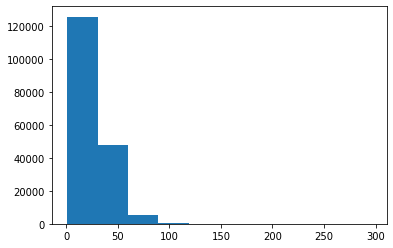

In [ ]:
# Plot distribution of lengths

import matplotlib.pyplot as plt
plt.hist(sentence_lens)

In [ ]:
# Find sentence len that cover 95% of lengths

output_seq_len = int(np.percentile(sentence_lens,95))
output_seq_len

55

In [ ]:
# Create text vectorizor

# n of words in vocap (taken from documentation, https://arxiv.org/pdf/1710.06071.pdf

max_tokens=68000

# create text vectorizor

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens, # number of words in vocabulary
                                    output_sequence_length = output_seq_len) # desired ooutpunt length of vectorized sequence, 55

In [ ]:
# read training data and determine which number should represent which word

text_vectorizer.adapt(train_sentences)

In [ ]:
# test vectorizor

import random

target_sentence = random.choice(train_sentences)

print(f"Text:\n {target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
 significant deviation existed among all groups ( p = @ ) .

Length of text: 12
nVectorized text:
[[  37 1551 5082  116   62   24   14    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
# Explore vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")
     


Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()
     


{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8'}

In [ ]:
# Capture relationship between words - create embedding

# Create embedding

token_embed = layers.Embedding(input_dim = len(rct_20k_text_vocab), # len of vocab,
                               output_dim = 128,
                               mask_zero = True,
                               name="token_embedding")

# Example embedding

print(f"Sentence before vectorization:\{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding:\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:\significant deviation existed among all groups ( p = @ ) .

Sentence after vectorization (before embedding:
[[  37 1551 5082  116   62   24   14    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[-0.02593501 -0.0135053  -0.00827839 ...  0.04719741 -0.02384074
    0.00472195]
  [-0.03470593 -0.00239132 -0.01043829 ...  0.04690291 -0.00621797
   -0.02526213]
  [-0.01608862  0.00987851 -0.0029556  ...  0.04469622  0.00874683
   -0.04268496]
  ...
  [ 0.03070723 -0.00050739  0.04282547 ... -0.0218832   0.03861204
   -0.00495019]
  [ 0.03070723 -0.00050739  0.04282547 ... -0.0218832   0.03861204
   -0.00495019]
  [ 0.03070723 -0.00050739  0.04282547 ... -0.0218832   0.03861204
   -0.00495019]]]

Embedded sentence shape: (1, 55, 128)


In [ ]:
# Creating datasets
# Turn into PrefetchDataset of batches (faster loading into GPU)
# https://www.tensorflow.org/guide/data
# https://www.tensorflow.org/guide/data_performance

# Turn data into Tensorflow datasets

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# MODEL 1: CONV1D with token embedings
# input (text) -> Tokenize -> Embedding -> Layers -> Output (probability)

inputs = layers.Input(shape=[1,], dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

     
# Get summary of Conv1D model
model_1.summary()
     


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
# TO save time, fit first 10% of batches (18k samples)

# Fit the model

model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1*len(train_dataset)), # fit on 10% of train dataset
                              epochs=3,
                              validation_data = valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))


Epoch 1/3
562/562 [==============================] - 36s 46ms/step - loss: 0.9199 - accuracy: 0.6343 - val_loss: 0.6873 - val_accuracy: 0.7327
Epoch 2/3
562/562 [==============================] - 9s 16ms/step - loss: 0.6608 - accuracy: 0.7525 - val_loss: 0.6327 - val_accuracy: 0.7689
Epoch 3/3
562/562 [==============================] - 5s 8ms/step - loss: 0.6196 - accuracy: 0.7725 - val_loss: 0.6001 - val_accuracy: 0.7826


In [ ]:
# Evaluate on whole validation dataset

model_1.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 0.6010 - accuracy: 0.7847


[0.601012647151947, 0.7846550941467285]

In [ ]:
# Make predictions (model ouputs probabilites for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[4.1194382e-01, 1.6033903e-01, 8.5294813e-02, 3.1662515e-01,
        2.5797118e-02],
       [4.5087749e-01, 3.1268585e-01, 1.2090308e-02, 2.1563452e-01,
        8.7118018e-03],
       [1.8319069e-01, 9.3334801e-03, 1.8517922e-03, 8.0559218e-01,
        3.1790896e-05],
       ...,
       [3.3429085e-06, 4.9330317e-04, 5.3117698e-04, 3.6369245e-06,
        9.9896860e-01],
       [6.4644858e-02, 4.6411625e-01, 9.3824990e-02, 8.3629727e-02,
        2.9378414e-01],
       [1.4617614e-01, 6.9226909e-01, 4.5424592e-02, 4.6308298e-02,
        6.9821924e-02]], dtype=float32)

In [ ]:
# Convert pred probs to classes

model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calculate model 1 results

model_1_results = calculate_results(y_true=val_labels_encoded, y_pred = model_1_preds)
model_1_results

{'accuracy': 78.46551039322124,
 'precision': 0.7811242953177054,
 'recall': 0.7846551039322124,
 'f1': 0.7818977836072024}

In [ ]:
# Model 2: Feature extraction with pretrained token embeddings

# Inputs(string) -> Pretrained embeddings (Universal Sentence Encoder) -> layers -> Output (probabilities)


#Download pretrained USE from TF Hub
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:


# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")
     


Random training sentence:
consequently , the aim of the current study was to comparatively evaluate the pharmacokinetic ( pk ) and pharmacodynamic ( pd anticonvulsant activity ) profile of emc and ipc individual enantiomers .

Sentence after embedding:
[-0.05239896 -0.00208592 -0.04444432 -0.05104978  0.03940014 -0.01804187
 -0.02275138 -0.02978023 -0.02291445  0.01577875  0.03577893 -0.04784426
 -0.01811165 -0.00740353  0.01308979  0.02672807 -0.07263214 -0.02524144
  0.03512403 -0.05772111 -0.00902088  0.03948447  0.05061202 -0.05968276
  0.08929484 -0.05195957 -0.01110593  0.05652479  0.06217256  0.0184713 ] (truncated output)...

Length of sentence embedding:
512


In [ ]:
# Define feature extractor model using TF Hub layer

inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation='relu')(pretrained_embedding) # add fully connected layer
outputs = layers.Dense(5, activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


# Get a summary of the model
model_2.summary()
     


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit feature extractor model for 3 epochs

model_2.fit(train_dataset,
            steps_per_epoch=int(0.1*len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 15ms/step - loss: 0.9194 - accuracy: 0.6486 - val_loss: 0.7957 - val_accuracy: 0.6918
Epoch 2/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7698 - accuracy: 0.7007 - val_loss: 0.7553 - val_accuracy: 0.7064
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7521 - accuracy: 0.7112 - val_loss: 0.7380 - val_accuracy: 0.7121


In [ ]:
# make predictions with feature extraction model

model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 10s 11ms/step


array([[4.1766465e-01, 3.8186255e-01, 2.1314772e-03, 1.8936509e-01,
        8.9762164e-03],
       [3.7529528e-01, 4.8320773e-01, 3.4801671e-03, 1.3516468e-01,
        2.8521575e-03],
       [2.3047686e-01, 1.5418896e-01, 1.7778527e-02, 5.5494571e-01,
        4.2609990e-02],
       ...,
       [1.6641731e-03, 7.3007876e-03, 5.7677917e-02, 8.6425542e-04,
        9.3249285e-01],
       [3.6507659e-03, 4.6260294e-02, 1.9092248e-01, 1.3822850e-03,
        7.5778419e-01],
       [1.5860520e-01, 2.5193238e-01, 5.2183545e-01, 7.3699350e-03,
        6.0256984e-02]], dtype=float32)

In [ ]:
# Convert predictions with feature extraction model to classes

model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results
     


{'accuracy': 71.3855421686747,
 'precision': 0.7146694136243291,
 'recall': 0.713855421686747,
 'f1': 0.7110679094977715}

In [ ]:
# Model 3: Conv1D with character embeddings

# Character embedding: Split sequence into characters and embedd -> each character gets turned into a feature vector


# Function to split sentences into characters

def split_chars(text):
  return " " .join(list(text))

# Test splitting non-character level seq into characters
split_chars(random_training_sentence)

'c o n s e q u e n t l y   ,   t h e   a i m   o f   t h e   c u r r e n t   s t u d y   w a s   t o   c o m p a r a t i v e l y   e v a l u a t e   t h e   p h a r m a c o k i n e t i c   (   p k   )   a n d   p h a r m a c o d y n a m i c   (   p d   a n t i c o n v u l s a n t   a c t i v i t y   )   p r o f i l e   o f   e m c   a n d   i p c   i n d i v i d u a l   e n a n t i o m e r s   .'

In [ ]:
# Split sequence-level data splits into character-level data splits

train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])


t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .


In [ ]:
# To figure on len of vectorised character sequencem check distirbution of our character seq len
# What's the average character length?

char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

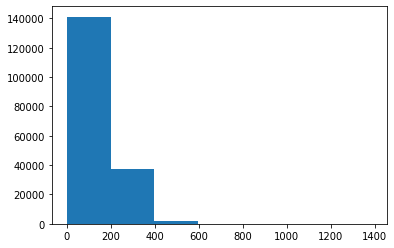

In [ ]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [ ]:
# Find out what character length cover 95% of sequqnces 

output_seq_char_len=int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char levele vectorizer instance (alphabet + space + unknown )

NUM_CHAR_TOKEN = len(alphabet) + 2
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKEN,
                                    output_sequence_length = output_seq_char_len,
                                    standardize = "lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab

char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer (check if its working)

random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f":\Length of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars :\{vectorized_chars}")
print(f"\nČength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
t h e   w a s h o u t   p e r i o d   b e t w e e n   t r e a t m e n t s   w a s   @   d a y s   .
:\Length of chars: 42

Vectorized chars :\[[ 3 13  2 20  5  9 13  7 16  3 14  2  8  4  7 10 22  2  3 20  2  2  6  3
   8  2  5  3 15  2  6  3  9 20  5  9 10  5 19  9  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0

In [ ]:
# Create char embedding layer

char_embed = layers.Embedding(input_dim = NUM_CHAR_TOKEN,
                               output_dim = 25,
                               mask_zero=False,
                               name="char_embed")

# Test out character imbedding layer

print(f"Charified text (before vectorization and embedding): \n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding): 
 t h e   w a s h o u t   p e r i o d   b e t w e e n   t r e a t m e n t s   w a s   @   d a y s   .

Embedded chars (after vectorization and embedding):
[[[-0.04371499 -0.03004829 -0.02942424 ...  0.03206556 -0.0326782
    0.03275967]
  [ 0.0424115  -0.03626758  0.03179835 ... -0.00613061  0.0173733
   -0.00424839]
  [ 0.0339232   0.00829905  0.02466256 ... -0.02451683 -0.0319002
   -0.01104628]
  ...
  [ 0.01084904 -0.01740036  0.01242244 ...  0.00656806  0.01682229
    0.03333649]
  [ 0.01084904 -0.01740036  0.01242244 ...  0.00656806  0.01682229
    0.03333649]
  [ 0.01084904 -0.01740036  0.01242244 ...  0.00656806  0.01682229
    0.03333649]]]

Character embedding shape: (1, 290, 25)


In [ ]:
# Build a Conv1D model
# Input(character-level text) -> Tokenize -> Embedding -> Layers (Conv1D, GlobalMaxPool1D) - > Output (label probability)

# Make Conv1D on chars only

inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model

model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Model summary
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5

In [ ]:
# create batch datasets

# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model (10% dataset)

model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data = val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset))
                              )

Epoch 1/3
562/562 [==============================] - 5s 6ms/step - loss: 1.2558 - accuracy: 0.4898 - val_loss: 1.0286 - val_accuracy: 0.5934
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9983 - accuracy: 0.6005 - val_loss: 0.9408 - val_accuracy: 0.6303
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9250 - accuracy: 0.6371 - val_loss: 0.8668 - val_accuracy: 0.6626


In [ ]:
# Eval model 3

model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.8851 - accuracy: 0.6579


[0.8851353526115417, 0.6578842997550964]

In [ ]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs
     


945/945 [==============================] - 2s 3ms/step


array([[0.201383  , 0.3219313 , 0.16468056, 0.18864968, 0.12335545],
       [0.19917639, 0.4138373 , 0.05412   , 0.17043307, 0.16243324],
       [0.12726666, 0.2400886 , 0.22020265, 0.36494017, 0.04750192],
       ...,
       [0.0132123 , 0.01833667, 0.09864467, 0.01541362, 0.8543927 ],
       [0.02925526, 0.14216861, 0.3154983 , 0.03701961, 0.4760582 ],
       [0.3198473 , 0.5259126 , 0.03473944, 0.11299899, 0.00650165]],
      dtype=float32)

In [ ]:
# Convert probabilites to classes

model_3_preds=tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 65.78842843903084,
 'precision': 0.6533210639612196,
 'recall': 0.6578842843903084,
 'f1': 0.6481706620901407}

In [ ]:
# Model 4: Pretrained token embeddings + character embeddings 
# 1. Create token level model (similar to model_1)
# 2. Create character level model (similar to model_3)
# 3. Cobine using layers.Concatenate outputs of 1 and 2
# 4. Build a series of output layers on top of 3


In [ ]:
#1. Create token model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Character level model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs = char_bi_lstm)

# 3. Concatenate token and char inputs (hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")



# Get summary of token and character model
model_4.summary()
     


Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

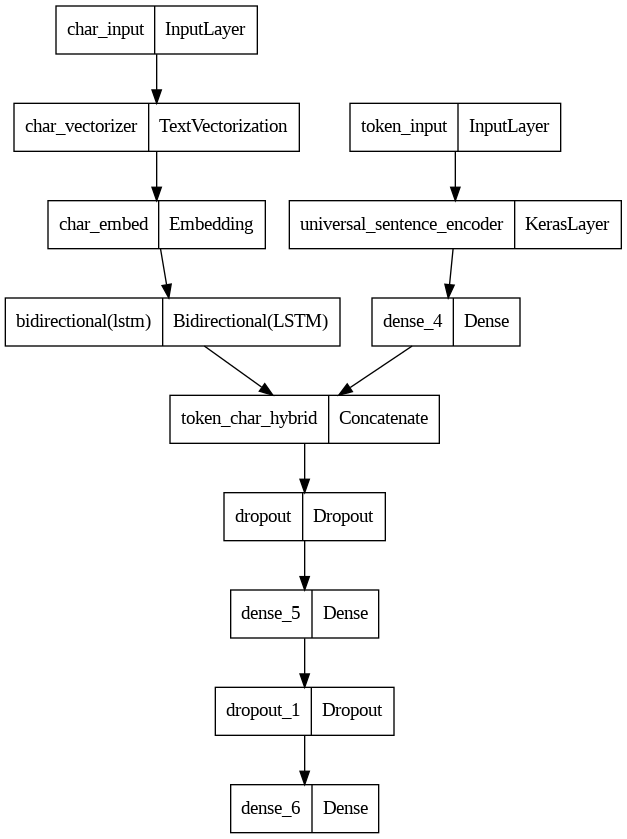

In [ ]:
# Plot hybrid token and char model

from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [ ]:
# Compile model 4

model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# model requires two imputs, token-level seqence and char-level sequence

# Combine chars and tokens into a dataset

train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices((train_labels_one_hot)) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) #make dataset 

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps for validation data 
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
     

In [ ]:
# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# fitting model on tokens and char
# Again, fit on 10% dataset

model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data = val_char_token_dataset,
                              validation_steps = int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 26s 35ms/step - loss: 0.9688 - accuracy: 0.6163 - val_loss: 0.7764 - val_accuracy: 0.6961
Epoch 2/3
562/562 [==============================] - 18s 33ms/step - loss: 0.7936 - accuracy: 0.6946 - val_loss: 0.7200 - val_accuracy: 0.7264
Epoch 3/3
562/562 [==============================] - 18s 32ms/step - loss: 0.7661 - accuracy: 0.7061 - val_loss: 0.6878 - val_accuracy: 0.7447


In [ ]:
# Evalueate model_4
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 17s 18ms/step - loss: 0.6945 - accuracy: 0.7356


[0.694485068321228, 0.7356348633766174]

In [ ]:
# Make predictions using the token-character model hybrid

model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 18s 18ms/step


array([[4.2533433e-01, 3.5885626e-01, 4.7888714e-03, 2.0329359e-01,
        7.7269669e-03],
       [3.3980852e-01, 4.6677643e-01, 3.0483133e-03, 1.8885987e-01,
        1.5068020e-03],
       [2.8803372e-01, 9.3252920e-02, 3.9833914e-02, 5.5651039e-01,
        2.2369063e-02],
       ...,
       [2.9132381e-04, 6.8191201e-03, 3.9909501e-02, 1.6472123e-04,
        9.5281529e-01],
       [6.0109743e-03, 6.1603576e-02, 2.0864603e-01, 3.4866170e-03,
        7.2025281e-01],
       [2.1263930e-01, 4.4035932e-01, 2.9048955e-01, 1.7542901e-02,
        3.8968991e-02]], dtype=float32)

In [ ]:
# Turn prob -> prediction classes

model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:


# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results
     


{'accuracy': 73.56348470806302,
 'precision': 0.7377033507501864,
 'recall': 0.7356348470806302,
 'f1': 0.7337991581991479}

In [ ]:
# Model 5 Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings
 # use one hot encoder to encode line number column
 # How many unique line numbers are there?

train_df["line_number"].value_counts()


0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

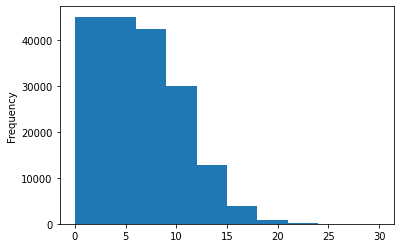

In [ ]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()
     

In [ ]:
# Based on line distribution, set depth of tf.one_host to 15

train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)


In [ ]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

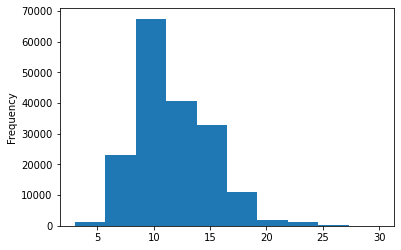

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98) # a value of 20 covers 98% of samples

20.0

In [ ]:
# Use tf to create one hot encoded tensors of the "total_lines" columns

train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)


# Check shape and samples of total lines one-hot tensor

train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

In [ ]:
# 1. Token inputs

token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

# 2. Char inputs

char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Total lines inputs

line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name='line_number_input')
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=x)

# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_line_model = tf.keras.Model(inputs=total_lines_inputs,
                                  outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(z)

# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 token_model.input, 
                                 char_model.input],
                         outputs=output_layer)



# Get a summary of our token, char and positional embedding model
model_5.summary()
     


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']     

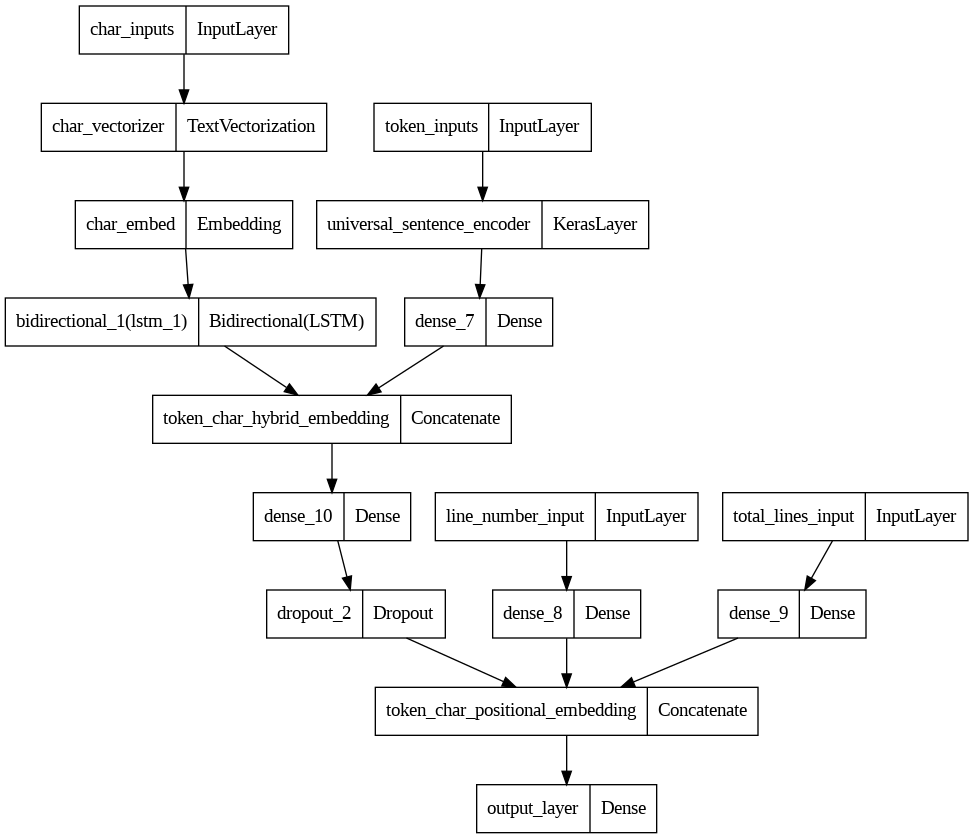

In [ ]:
# Plot the token, char, positional embedding model
from tensorflow.keras.utils import plot_model
plot_model(model_5)
     


In [ ]:
for layer in model_5.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fc749d0c130> True
<keras.engine.input_layer.InputLayer object at 0x7fc749d06be0> True
<keras.layers.preprocessing.text_vectorization.TextVectorization object at 0x7fc6e907c310> True
<tensorflow_hub.keras_layer.KerasLayer object at 0x7fc7b8361c10> False
<keras.layers.core.embedding.Embedding object at 0x7fc6e902df10> True
<keras.layers.core.dense.Dense object at 0x7fc749d06f70> True
<keras.layers.rnn.bidirectional.Bidirectional object at 0x7fc749cd94f0> True
<keras.layers.merging.concatenate.Concatenate object at 0x7fc749c19c40> True
<keras.engine.input_layer.InputLayer object at 0x7fc749cd9130> True
<keras.engine.input_layer.InputLayer object at 0x7fc749cfc1f0> True
<keras.layers.core.dense.Dense object at 0x7fc749c05c40> True
<keras.layers.core.dense.Dense object at 0x7fc749bdd670> True
<keras.layers.core.dense.Dense object at 0x7fc749c54130> True
<keras.layers.regularization.dropout.Dropout object at 0x7fc7516db670> True
<keras.layers

In [ ]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Create hibrid embedding datasets and fit model

# Create training and validation datasets (all four kinds of inputs)
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                train_sentences, # train tokens
                                                                train_chars)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Check input shapes
train_pos_char_token_dataset, val_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:


# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))
     


Epoch 1/3
562/562 [==============================] - 27s 37ms/step - loss: 1.0952 - accuracy: 0.7243 - val_loss: 0.9808 - val_accuracy: 0.8062
Epoch 2/3
562/562 [==============================] - 18s 33ms/step - loss: 0.9670 - accuracy: 0.8139 - val_loss: 0.9492 - val_accuracy: 0.8321
Epoch 3/3
562/562 [==============================] - 18s 31ms/step - loss: 0.9517 - accuracy: 0.8225 - val_loss: 0.9407 - val_accuracy: 0.8321


In [ ]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 19s 19ms/step


array([[0.4982248 , 0.11780719, 0.0131083 , 0.3514101 , 0.01944958],
       [0.5500718 , 0.10208377, 0.05084854, 0.28559023, 0.01140562],
       [0.25206035, 0.11721396, 0.11479182, 0.45495138, 0.06098255],
       ...,
       [0.03879737, 0.10725796, 0.04125151, 0.03095965, 0.78173345],
       [0.03222331, 0.32085803, 0.07071803, 0.0272403 , 0.5489604 ],
       [0.23392569, 0.578385  , 0.08934659, 0.03656205, 0.06178065]],
      dtype=float32)

In [ ]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results


{'accuracy': 83.11598040513704,
 'precision': 0.8300430337938948,
 'recall': 0.8311598040513704,
 'f1': 0.8301790646492789}

In [ ]:
# Compare model results

# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results
     


,accuracy,precision,recall,f1
baseline,72.183238,0.718647,0.721832,0.698925
custom_token_embed_conv1d,78.465510,0.781124,0.784655,0.781898
pretrained_token_embed,71.385542,0.714669,0.713855,0.711068
custom_char_embed_conv1d,65.788428,0.653321,0.657884,0.648171
hybrid_char_token_embed,73.563485,0.737703,0.735635,0.733799
tribrid_pos_char_token_embed,83.115980,0.830043,0.831160,0.830179


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
     


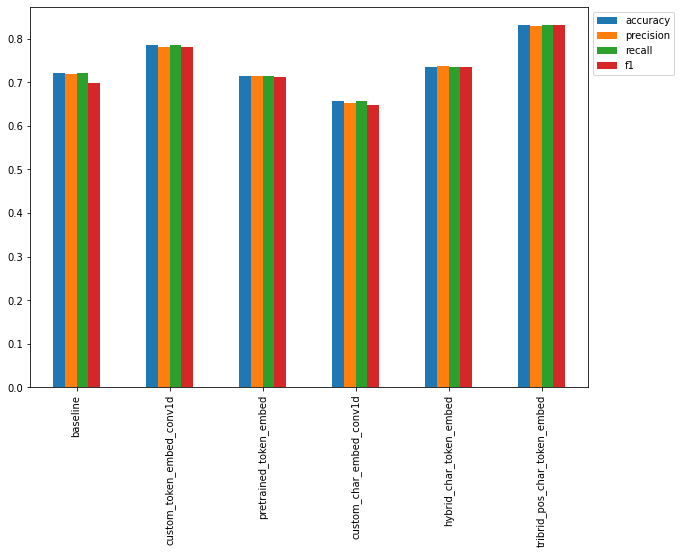

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

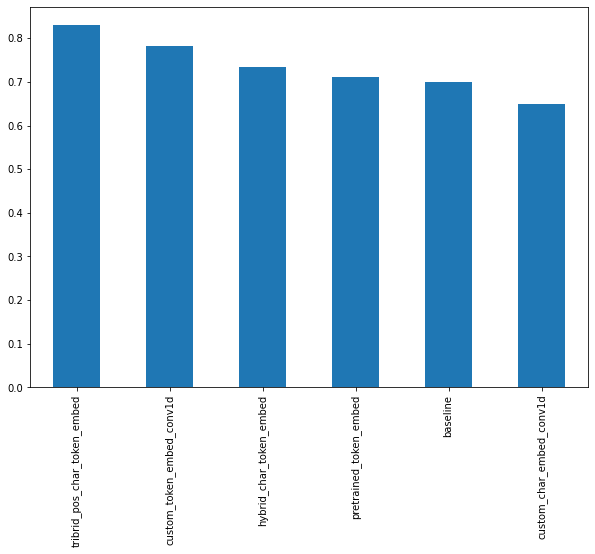

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));


In [ ]:
# Save best peforming model (model_5)
model_5.save("skimlit_tribrid_model") # model will be saved to path specified by string